## Проектная работа по модулю “Математика и статистика в Python”

1. Загрузить файл hr.csv
2. Рассчитать основные статистики для переменных (среднее,медиана,мода,мин/макс,сред.отклонение).
3. Рассчитать и визуализировать корреляционную матрицу для переменных.
4. Визуализировать несколько взаимосвязей между переменными.
5. С использованием t-test статистики проверить взаимосвязи между несколькими переменными.
6. Рассчитать сколько работников работает в каждом департаменте.
7. Показать распределение сотрудников по зарплатам.
8. Показать распределение сотрудников по зарплатам совместно с департаментами.
9. Сколько сотрудников покинули компанию.
10. Проверить несколько гипотез для данных, чтобы понять почему сотрудники покидают компанию.
11. Загрузить результат (в формате .ipynb ноутбука) в репозиторий. Разместить ссылку на репозиторий в Личном кабинете

In [11]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns
import statistics
%matplotlib inline

__1. Загрузить файл hr.csv__

In [535]:
data=pd.read_csv('hr.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


*Супер! Dataset чистый, NaN - ов нет.  соответствует стандартному описанию hr.csv.  Только столбец Department здесь называется Sales. Но это нам не мешает.*

In [536]:
#Чтобы сделать более наглядной работу с Dataset, переименуем столбцы на более короткие
names = ['SL', 'LEV', 'NP', 'AMH', 'TSC', 'WA', 'LEFT', 'PL5Y', 'DEP', 'SAL']
data.columns = names

In [537]:
data.head()

,SL,LEV,NP,AMH,TSC,WA,LEFT,PL5Y,DEP,SAL
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


**2. Рассчитать основные статистики для переменных (среднее,медиана,мода,мин/макс,сред.отклонение).**

In [538]:
#Самый простой способ это сделать - describe
data.describe()

,SL,LEV,NP,AMH,TSC,WA,LEFT,PL5Y
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


_Вот только моды в этой таблице нет.  Рассчитаем отдельно._

In [539]:
for i in range(data.shape[1]):
    try:    
        print("Мода столбца ", data.columns[i], "= ", statistics.mode(data.iloc[:, i]))
    except statistics.StatisticsError:
        print("При расчете моды столбца ", data.columns[i], "возникла ошибка.  Нет уникальной моды")   

Мода столбца  SL =  0.1
Мода столбца  LEV =  0.55
Мода столбца  NP =  4
При расчете моды столбца  AMH возникла ошибка.  Нет уникальной моды
Мода столбца  TSC =  3
Мода столбца  WA =  0
Мода столбца  LEFT =  0
Мода столбца  PL5Y =  0
Мода столбца  DEP =  sales
Мода столбца  SAL =  low


_Видно, что при расчете моды 4-го столбца (i=3) возникла ошибка, связанная с отсутствием уникальной моды.  Т.е. два или больше значений списка встречаются одинаково часто._  

**3. Рассчитать и визуализировать корреляционную матрицу для переменных.**

_Перед расчетом корреляций я бы изменил формат данных в столбеце Sales.  Скорей всего, уровень заработной платы сильно коррелирует с рядом остальных величин, но эта корреляция не будет рассчитана для текстового формата.  Поэтому сделаем его int.  Ведем еще один столбец SALI_

In [540]:
data['SAL'].unique()

array(['low', 'medium', 'high'], dtype=object)

In [541]:
ren = {'low': 0, 'medium': 1, 'high': 2}
data['SALI'] = data['SAL'].map(ren)
data['SALI']

0        0
1        1
2        1
3        0
4        0
        ..
14994    0
14995    0
14996    0
14997    0
14998    0
Name: SALI, Length: 14999, dtype: int64

In [542]:
#Рассчитаем и визуализируем средствами Pandas
corr = data.corr()
corr = corr.round(2)
corr.style.background_gradient(cmap='coolwarm')

,SL,LEV,NP,AMH,TSC,WA,LEFT,PL5Y,SALI
SL,1,0.11,-0.14,-0.02,-0.1,0.06,-0.39,0.03,0.05
LEV,0.11,1,0.35,0.34,0.13,-0.01,0.01,-0.01,-0.01
NP,-0.14,0.35,1,0.42,0.2,-0,0.02,-0.01,-0
AMH,-0.02,0.34,0.42,1,0.13,-0.01,0.07,-0,-0
TSC,-0.1,0.13,0.2,0.13,1,0,0.14,0.07,0.05
WA,0.06,-0.01,-0,-0.01,0,1,-0.15,0.04,0.01
LEFT,-0.39,0.01,0.02,0.07,0.14,-0.15,1,-0.06,-0.16
PL5Y,0.03,-0.01,-0.01,-0,0.07,0.04,-0.06,1,0.1
SALI,0.05,-0.01,-0,-0,0.05,0.01,-0.16,0.1,1


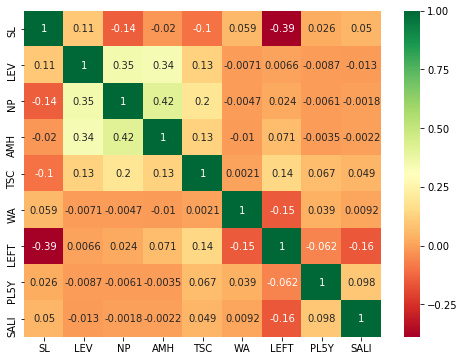

In [543]:
#И визуализируем средствами Seaborn
ax = sns.heatmap(data.corr(),annot=True,cmap='RdYlGn') 
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)
fig=plt.gcf()
fig.set_size_inches(8,6)
plt.show()

**4. Визуализировать несколько взаимосвязей между переменными.**

_Хотелось бы посмотреть на взаимосвязь наиболее сильно коррелирующих переменных, как то:_
- LEFT-SL = Зависимость числа уволившихся от степени удовлетворенности, 
- LEV-NP = Зависимость результатов аттестатции от числа проектов сотрудника,
- LEFT-SAL = Зависимость числа уволившихся от уровня зарплаты

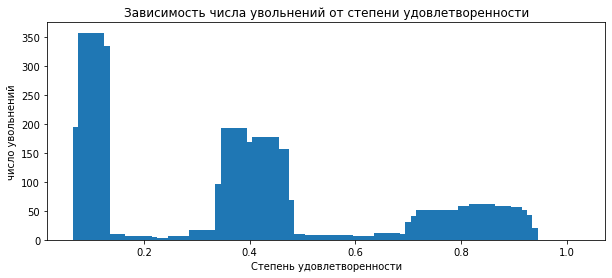

In [545]:
df = data.groupby('SL').sum().reset_index() #Используем sum, потому что критерий увольнения 0|1.
plt.figure(figsize=(10,4))
plt.bar(df['SL'], df['LEFT'], width = 0.05)
plt.xlabel('Степень удовлетворенности')
plt.ylabel('число увoльнений')
plt.title('Зависимость числа увoльнений от степени удовлетворенности')
plt.show()

_Прикольно...  Чаще всего увольняются сотрудники с низкой стпенеью удовлетворенности (мотивации) = это понятно.  Но вот почему увольняются сотрудники с высокой и средней?  Надо посмотреть вообще распределение сотрудников по уровню мотивации._

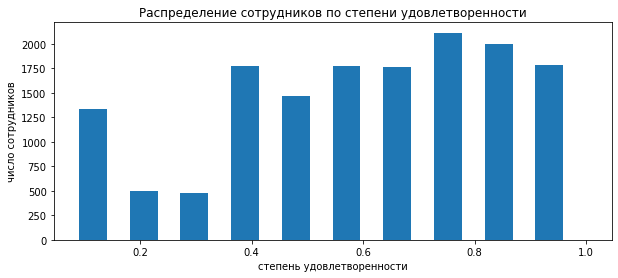

In [546]:
df = data.groupby('SL').count().reset_index() #Используем count,считаем всех.
plt.figure(figsize=(10,4))
plt.hist(data['SL'], width = 0.05)
plt.xlabel('степень удовлетворенности')
plt.ylabel('число сотрудников')
plt.title('Распределение сотрудников по степени удовлетворенности')
plt.show()

_ну вот и разрешилась загадка.  Просто сотрудников с "промежуточной" мотивацией (от 0.1 до 0.4) мало.  Она или совсем низкая, или выше 0.4.  

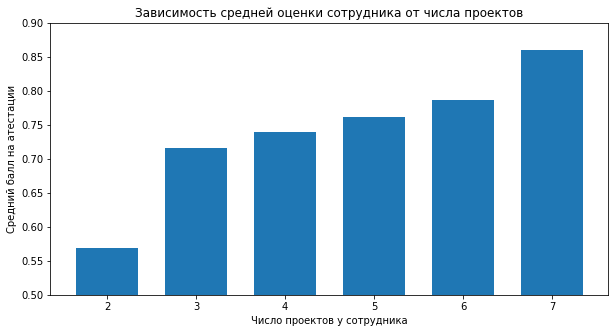

In [547]:
df = data.groupby('NP').mean().reset_index()
plt.figure(figsize=(10,5))
plt.bar(df['NP'], df['LEV'], width = 0.7)
plt.xlabel('Число проектов у сотрудника')
plt.ylim(0.5, 0.9)
plt.ylabel('Средний балл на атестации')
plt.title('Зависимость средней оценки сотрудника от числа проектов')
plt.show()

_Здесь все понятно - чем больше сотрудник делает проектов, тем выше его оценка на аттестации_

      SAL       SL      LEV     NP      AMH    TSC    WA  LEFT  PL5Y  SALI
1     low  4395.11  5245.70  27800  1470491  25154  1040  2172    66     0
2  medium  4008.23  4623.86  24582  1297827  22748   937  1317   181  6446
0    high   788.55   871.25   4660   247236   4568   192    82    72  2474


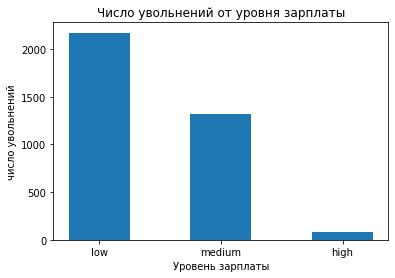

In [548]:
df = data.groupby('SAL').sum().reset_index().sort_values('LEFT', ascending = False)
print(df)
plt.figure(figsize=(6, 4))
plt.bar(df['SAL'], df['LEFT'], width = 0.5)
plt.xlabel('Уровень зарплаты')
plt.ylabel('число увoльнений')
plt.title('Число увoльнений от уровня зарплаты')
plt.show()

_Реже всего увольняются сотрудники с высокой зарплатой._

**5. С использованием t-test статистики проверить взаимосвязи между несколькими переменными.**

_Проверим взаимосвязь между степенью удовлетворенности сотрудников, работающих в различных депатраментах_

In [549]:
#Какие у нас есть департаменты
data['DEP'].unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

_Далее посмотрим, насколько отличаются аттестационные оценки для сотрудников различных департаментов.  0 - гипотеза - различий нет.  Сделаем выборки для sales, technical и support_

In [550]:
tech_dist = data[data['DEP'] == 'technical'].groupby('LEV').count().reset_index()[['LEV','SL']]
supp_dist = data[data['DEP'] == 'support'].groupby('LEV').count().reset_index()[['LEV','SL']]
sales_dist = data[data['DEP'] == 'sales'].groupby('LEV').count().reset_index()[['LEV','SL']]

Сделаем единый датасет

In [551]:
tech_dist.columns = ['LEV','technical']
supp_dist.columns = ['LEV','support']
sales_dist.columns = ['LEV','sales']
tech_dist = tech_dist.merge(supp_dist, on = 'LEV', how='inner')
tech_dist = tech_dist.merge(sales_dist, on = 'LEV',how='inner')
tech_dist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65 entries, 0 to 64
Data columns (total 4 columns):
LEV          65 non-null float64
technical    65 non-null int64
support      65 non-null int64
sales        65 non-null int64
dtypes: float64(1), int64(3)
memory usage: 2.5 KB


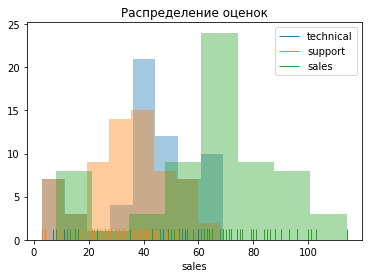

In [552]:
sns.distplot(tech_dist['technical'], kde=False, rug=True)
sns.distplot(tech_dist['support'], kde=False, rug=True)
sns.distplot(tech_dist['sales'], kde=False, rug=True)
plt.title('Распределение оценок')
plt.legend(['technical', 'support', 'sales'])
plt.show()

Нормализуем значения выборок

In [553]:
headers = list(tech_dist.columns.values)

In [554]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

np_scaled = min_max_scaler.fit_transform(tech_dist)
dist_norm = pd.DataFrame(np_scaled)

In [555]:
dist_norm.columns = headers

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015C02B79D30>,
      dtype=object)

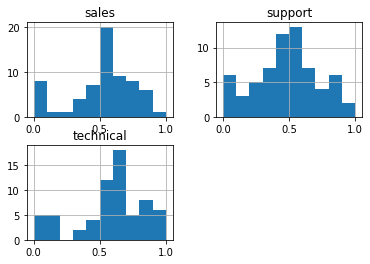

In [556]:
dist_norm[['technical', 'support', 'sales']].hist()

Проверим распределения на нормальность 

In [557]:
stat, p = normaltest( dist_norm['technical'])
print('technical stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Похоже, Гаусс')
else:
    print('Похоже, не Гаусс')
    
stat, p = normaltest( dist_norm['support'])
print('support stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Похоже, Гаусс')
else:
    print('Похоже, не Гаусс')
    
stat, p = normaltest( dist_norm['sales'])
print('sales stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Похоже, Гаусс')
else:
    print('Похоже, не Гаусс')

technical stat=5.214, p=0.074
Похоже, Гаусс
support stat=0.631, p=0.729
Похоже, Гаусс
sales stat=4.347, p=0.114
Похоже, Гаусс


Отлично.  Все распределения можно считать Гауссовыми.  Сделаем множественный ANOVA тест.

In [558]:
stats.f_oneway(dist_norm['technical'], dist_norm['support'], dist_norm['sales'])

F_onewayResult(statistic=3.173149208485238, pvalue=0.04407622150924132)

Так как результат p-value меньше 0.05, то мы отвергаем нулевую гипотезу о том, что нет различий в оценках сторудников разных департаметов.  Чуть не дотянули... Далее сравним из парными t - тестами.

In [561]:
print(stats.ttest_ind(dist_norm['technical'], dist_norm['support']))

Ttest_indResult(statistic=2.465959194836879, pvalue=0.01498818907626302)


Нулевая гипотеза для technical и support департаментов не подтверждается

In [562]:
print(stats.ttest_ind(dist_norm['technical'], dist_norm['sales']))

Ttest_indResult(statistic=1.4585605524924488, pvalue=0.1471355666554297)


Нулевая гипотеза о зависимости выборок для technical и sales департементов подтверждается

In [563]:
print(stats.ttest_ind(dist_norm['sales'], dist_norm['support']))

Ttest_indResult(statistic=1.059931918130036, pvalue=0.2911715504506842)


Нулевая гипотеза о схожести распределений оценок для департамента sales и support подтверждается.

_Основываясь на проведенном анализе, можно сделать вывод, что квалификация сотрудников, работающих в трех выбранных департаментах, распределяется похожим образом. Наибольшие отличия между сотрудниками technical и support департаментами._

**6. Рассчитать сколько работников работает в каждом департаменте.**

In [565]:
df = data.groupby('DEP').count().reset_index().iloc[:, 0:2]
df.columns = ['department', 'headcount']
print(df)

    department  headcount
0           IT       1227
1        RandD        787
2   accounting        767
3           hr        739
4   management        630
5    marketing        858
6  product_mng        902
7        sales       4140
8      support       2229
9    technical       2720


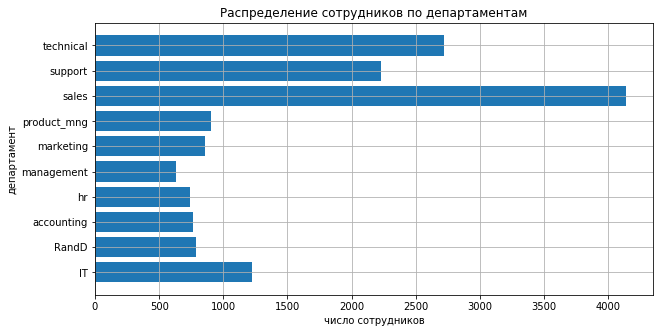

In [566]:
#и еще так
plt.figure(figsize=(10, 5))
plt.barh(df['department'], df['headcount'])
plt.ylabel('департамент')
plt.xlabel('число сотрудников')
plt.grid()
plt.title('Распределение сотрудников по департаментам')
plt.show()

**7. Показать распределение сотрудников по зарплатам.**

   salary  headcount
1     low       7316
2  medium       6446
0    high       1237


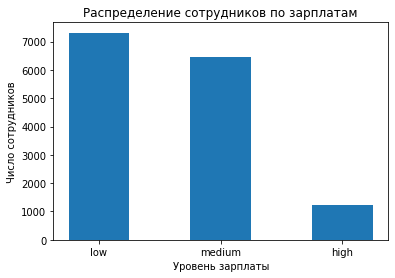

In [567]:
df = data.groupby('SAL').count().reset_index().sort_values('LEFT', ascending = False).iloc[:, 0:2]
df.columns = ['salary', "headcount"]
print(df)
plt.figure(figsize=(6, 4))
plt.bar(df['salary'], df['headcount'], width = 0.5)
plt.xlabel('Уровень зарплаты')
plt.ylabel('Число сотрудников')
plt.title('Распределение сотрудников по зарплатам')
plt.show()

**8. Показать распределение сотрудников по зарплатам совместно с департаментами.**

In [568]:
df = data.groupby(['DEP', 'SAL']).count().reset_index().iloc[:, 0:3]
df.style.bar()

,DEP,SAL,SL
0,IT,high,83
1,IT,low,609
2,IT,medium,535
3,RandD,high,51
4,RandD,low,364
5,RandD,medium,372
6,accounting,high,74
7,accounting,low,358
8,accounting,medium,335
9,hr,high,45


In [569]:
pivot_df = df.pivot(index='DEP', columns='SAL', values='SL')
pivot_df

SAL,high,low,medium
DEP,,,
IT,83,609,535
RandD,51,364,372
accounting,74,358,335
hr,45,335,359
management,225,180,225
marketing,80,402,376
product_mng,68,451,383
sales,269,2099,1772
support,141,1146,942


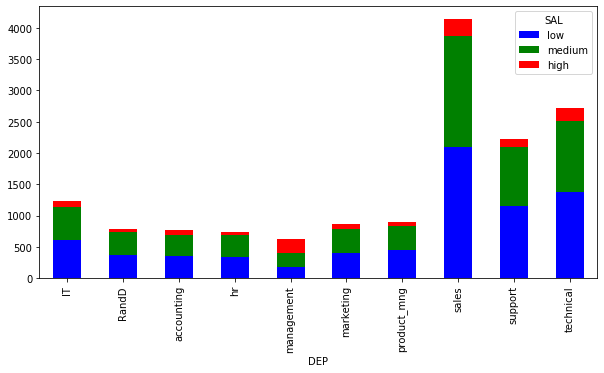

In [570]:
colors = ["b","g","r"]
pivot_df.loc[:,['low', 'medium','high']].plot.bar(stacked=True, color=colors, figsize=(10,5))

**9. Сколько сотрудников покинули компанию.**

In [571]:
print("Компанию покинули ", len(data[data['LEFT'] == 1]), "сотрудников")

Компанию покинули  3571 сотрудников


**10. Проверить несколько гипотез для данных, чтобы понять почему сотрудники покидают компанию.**

_Сначала пострим зависимость числа уволившихся сотрудников от нескольких переменных._

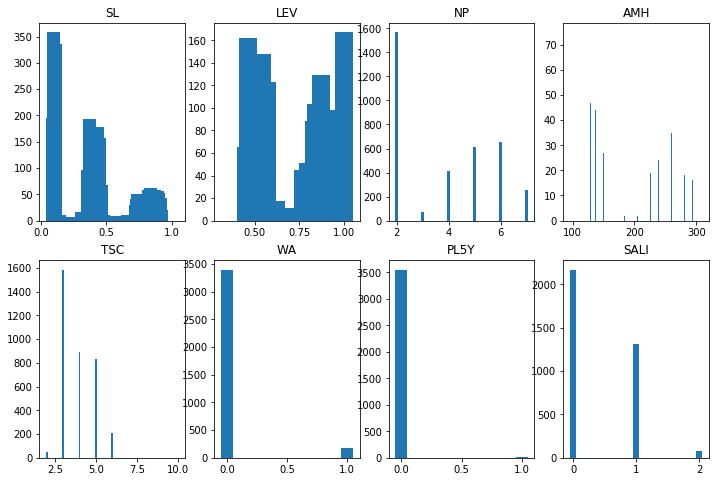

In [572]:
factors = ['SL', 'LEV', 'NP', 'AMH', 'TSC', 'WA', 'PL5Y', 'SALI']

fig, ax = plt.subplots(2,4, figsize = (12,8))

k = 0
for i in range(2):
    for j in range(4):
        var = factors[k]
        df = data.groupby(var).sum().reset_index()[[var,'LEFT']]
        ax[i,j].set(title = var)
        ax[i,j].bar(df[var], df['LEFT'], width = 0.1)
        k += 1
    
plt.show()



_Визуальный анализ распределений позволяет предположить, что наиболее "увольняемые" сотрудики: а)  имеют низкую мотивацию; б) Работают с менее, чем 3 - мя проектами; в) Имели инциденты на рабочем месте; г) Не повышались в течение последних 5 - ти лет; д) Получают низкую и среднюю зарплату._

_Выдвинем первую гипотезy:_
1. С большой вероятностью причиной увольнения является отсутствие повышений грейда за последние пять лет

In [412]:
data.groupby('PL5Y').sum().reset_index()['LEFT']

0    3552
1      19
Name: LEFT, dtype: int64

Ну тут даже проверять нечего.  Более 99% всех уволившихся - сотрудники, не получавшие повышения в течение последних пяти лет.

In [420]:
data.groupby('SAL').sum().reset_index()[['SAL','LEFT']]

,SAL,LEFT
0,high,82
1,low,2172
2,medium,1317


То же самое можно сказать про зарплату, как причину увольнения - более 97% уволившихся, люди с маленькой и средней зарплатой.

_Следовательно, указанные выше две причины являются основными причинами увольнений сотрудников.  Далее попробуем исследовать менее явные закономероности. Сформулируем гиптезу:  число уволившихся сотрудников не зависит от оценки, полученной на аттестации.  Для проверки этой гипотезы сформируем две выборки: уволившиеся с низкой оценкой и уволившиеся с высокой оценкой.  Граница - медиана в столбце LEV = 0.72_  

In [573]:
left_low = data[(data['LEV'] <= 0.72) & (data['LEFT'] == 1)].groupby('LEV').sum().reset_index()[['LEV', 'LEFT']]
left_high = data[(data['LEV'] > 0.72) & (data['LEFT'] == 1)].groupby('LEV').sum().reset_index()[['LEV', 'LEFT']]

<BarContainer object of 28 artists>

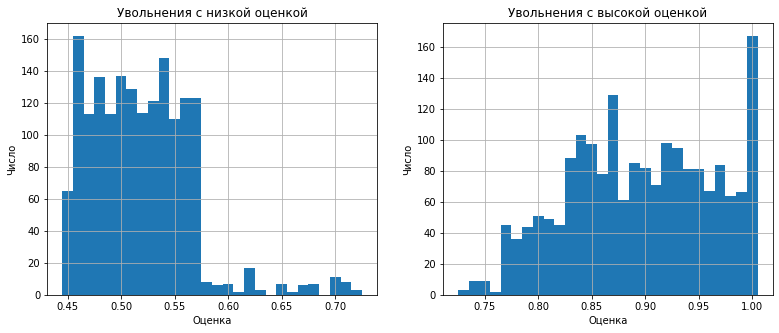

In [574]:
fig, ax = plt.subplots(1,2, figsize = (13,5))
ax[0].set(title = 'Увольнения с низкой оценкой', 
          xlabel = 'Оценка', 
          ylabel = 'Число')
ax[1].set(title = 'Увольнения с высокой оценкой', 
          xlabel = 'Оценка', 
          ylabel = 'Число')
ax[0].grid(True)
ax[1].grid(True)
ax[0].bar(left_low['LEV'], left_low['LEFT'], width = 0.01)
ax[1].bar(left_high['LEV'], left_high['LEFT'], width = 0.01)

In [575]:
print("Число уволившихся с низкой оценкой = ", left_low['LEFT'].sum(), \
      "\nЧисло уволившихся с высокой оценкой = ", left_high['LEFT'].sum())

Число уволившихся с низкой оценкой =  1681 
Число уволившихся с высокой оценкой =  1890


_Гипотеза подтвердилась - число уволившихся не зависит от оценки на последней аттестации._